## Place Field, different ways

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [75]:
from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

In [15]:
import matplotlib
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,TetrodeNumber,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,find_spikes
                            )
from spyglass.shijiegu.fragmented import permute_frag_cont,find_spike_count_ratio,get_nwb_units,classify_cells,find_firing_cross_correlation
from spyglass.shijiegu.placefield import cell_by_arm

from spyglass.shijiegu.Analysis_SGU import get_linearization_map,segment_to_linear_range
from spyglass.shijiegu.theta import return_skaggs_theta, return_theta_phase_location

import xarray as xr
from scipy.ndimage.filters import gaussian_filter

In [6]:
nwb_copy_file_name = "eliot20221022_.nwb"
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221022_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221022_ 2         02_Seq2Session pos 1 valid ti
eliot20221022_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221022_ 4         04_Seq2Session pos 3 valid ti
eliot20221022_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221022_ 6         06_Seq2Session pos 5 valid ti
eliot20221022_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221022_ 8         08_Seq2Session pos 7 valid ti
eliot20221022_ 9         09_Seq2Sleep5  pos 8 valid ti
eliot20221022_ 10        10_Seq2Session pos 9 valid ti
eliot20221022_ 11        11_Seq2Sleep6  pos 10 valid t
 (Total: 11)



In [7]:
epoch_num = 3
session_name = run_session_names[epoch_num]
pos_name = pos_session_names[epoch_num]

In [9]:
ripple_times = pd.DataFrame((RippleTimesWithDecode & 
                             {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': session_name}).fetch1('ripple_times'))

### 1. Get spike

In [10]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}

sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))
sort_group_ids_with_good_cell = []
for sort_group_id in sort_group_ids:
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id)
    if len(nwb_units)==0:
        continue
    sort_group_ids_with_good_cell.append(sort_group_id)
print("sort groups are: ",sort_group_ids_with_good_cell)

nwb_units_all = get_nwb_units(nwb_copy_file_name,session_name,sort_group_ids_with_good_cell)
count_ratio, firing_rate_F, firing_rate_C = find_spike_count_ratio(nwb_units_all,ripple_times)
cells_frag, cells_cont = classify_cells(firing_rate_F, firing_rate_C)

cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in nwb_units_all[e].index:
        cell_list.append((e, u))

sort groups are:  [0, 2, 5, 13, 14, 16, 17, 20, 23, 26, 27, 30, 31]
electrode 0 unit 3
during fragmented replay:  7.304430676138095 31.0
during cont replay:  3.709264109928835 84.0
electrode 0 unit 4
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.04415790607058137 1.0
electrode 0 unit 6
during fragmented replay:  2.8275215520534562 12.0
during cont replay:  1.9871057731761617 45.0
electrode 0 unit 7
during fragmented replay:  3.5344019400668203 15.0
during cont replay:  0.7506844031998833 17.0
electrode 0 unit 8
during fragmented replay:  1.1781339800222734 5.0
during cont replay:  0.1324737182117441 3.0
electrode 2 unit 3
during fragmented replay:  2.356267960044547 10.0
during cont replay:  1.1481055578351156 26.0
electrode 5 unit 2
during fragmented replay:  0.0 0.0
during cont replay:  0.9273160274822088 21.0
electrode 5 unit 5
during fragmented replay:  2.120641164040092 9.0
during cont replay:  0.30910534249406957 7.0
electrode 5 unit 6
during fragmente

### 2. get behavior

In [12]:
StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_name}).fetch1('choice_reward'))

trial_1_t = StateScript.loc[1].timestamp_O
trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O

In [62]:
# 
pos1d = (IntervalLinearizedPosition() & {'nwb_file_name': nwb_copy_file_name,
                                                        'track_graph_name':'4 arm lumped 2023',
                                                        'interval_list_name':pos_name,
                                                        'position_info_param_name':'default'}).fetch1_dataframe()

pos2d = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                                                        'interval_list_name':pos_name,
                                                        'position_info_param_name':'default'}).fetch1_dataframe()
pos1d = removeDataBeforeTrial1(pos1d,trial_1_t,trial_last_t)
pos2d = removeDataBeforeTrial1(pos2d,trial_1_t,trial_last_t)

[13:04:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


### 3. use Shijie's default method to make plots

In [398]:
from spyglass.shijiegu.placefield import place_field as default_placefield
from spyglass.shijiegu.fragmented_graph import cell_name_to_ind

In [410]:
placefields = {}
mobility_spike_counts = {}
all_spike_counts = {}
peak_frs = {}
for row_ind in range(len(cell_list)):
    print(row_ind)
    e = cell_list[row_ind][0]
    u = cell_list[row_ind][1]
    placefield, peak_fr, xbins, ybins, mobility_spike_count, all_spike_count = default_placefield(
        nwb_copy_file_name, session_name, pos_name, e, u)
    placefields[(e,u)] = placefield
    peak_frs[(e,u)] = peak_fr
    mobility_spike_counts[(e,u)] = mobility_spike_count
    all_spike_counts[(e,u)] = all_spike_count

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


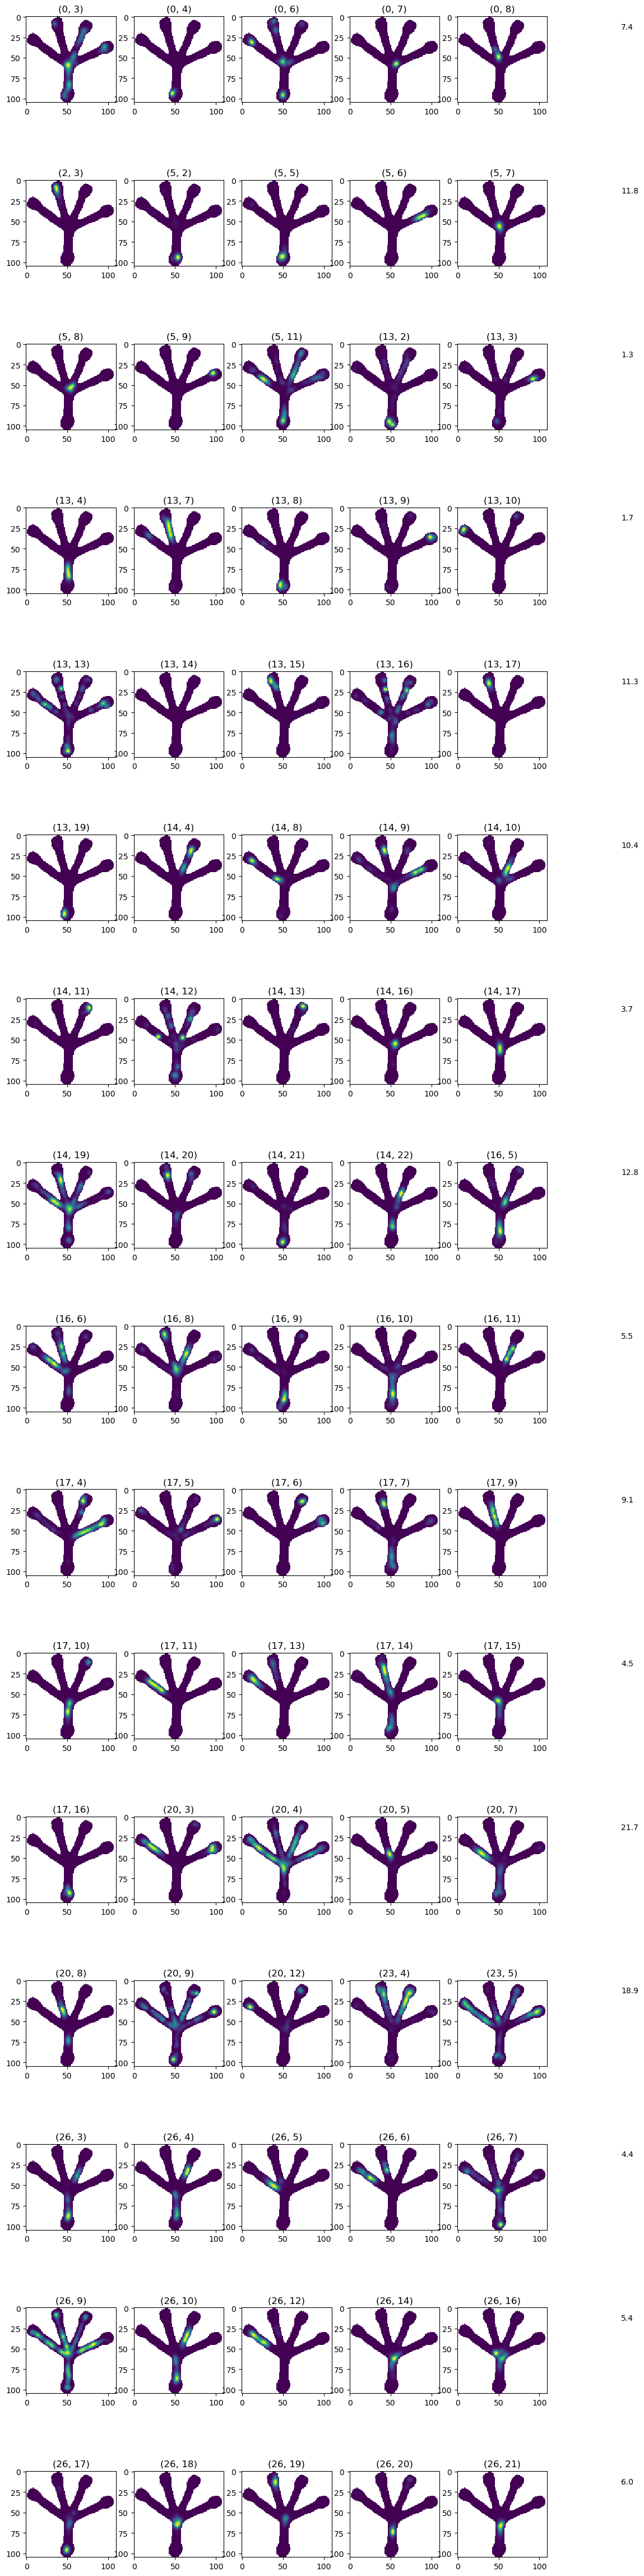

In [411]:
cells_to_plot = cell_list[:80]
    
fig, axes = plt.subplots(16,int(np.ceil(len(cells_to_plot)/16)), figsize = (12,60), squeeze = True)

ind = 0
for p in cells_to_plot:
    (e,u) = p
    cell_ind = cell_name_to_ind(p,cell_list)
    axes[np.unravel_index(ind, axes.shape)].imshow(placefields[(e,u)],
                                                   vmax = np.nanquantile(placefields[(e,u)],0.999),
                                                   vmin = np.nanquantile(placefields[(e,u)],0.4)
                                                  )
    axes[np.unravel_index(ind, axes.shape)].set_title(p)
    axes[np.unravel_index(ind, axes.shape)].text(200,15,round(peak_frs[(e,u)],1))
    ind = ind + 1

### 4. play with different ways to plot place field

In [392]:
(e,u) = (26,17) #(16,5) #(30,3), (26,17), (14,17)

In [393]:
spike_time = nwb_units_all[e].loc[u].spike_times
spike_time = spike_time[np.logical_and(spike_time>=trial_1_t,
                                       spike_time<=trial_last_t)]

In [394]:
BINWIDTH = 2 # 2cm
sigma = 2 # 4cm
upsampling_interpolation_method = 'linear' #or linear, which is bad, play with it.

# mobility only position data
mobility_index = np.argwhere(pos2d.head_speed > 4).ravel() # >4cm/s
pos1d_mobility = pos1d.iloc[mobility_index]
pos2d_mobility = pos2d.iloc[mobility_index]

pos2d_spike_time_all = interpolate_to_new_time(pos2d,spike_time,upsampling_interpolation_method = upsampling_interpolation_method)
mobility_index = np.argwhere(pos2d_spike_time_all.head_speed > 4).ravel() # >4cm/s
pos2d_spike_time = pos2d_spike_time_all.iloc[mobility_index]

spike_count = len(pos2d_spike_time)

# Define bins for all position for counting
xmin = np.min(pos2d_mobility.head_position_x)-10
xmax = np.max(pos2d_mobility.head_position_x)+10
ymin = np.min(pos2d_mobility.head_position_y)-10
ymax = np.max(pos2d_mobility.head_position_y)+10
xbins = np.arange(xmin,xmax + BINWIDTH,BINWIDTH)
ybins = np.arange(ymin,ymax + BINWIDTH,BINWIDTH)

delta_t = np.mean(np.diff(pos2d.index)) #for later, translating the unit of time number bins to time in seconds

# place field, aka occupancy normalized firing rate, aka P(spike | location)
# Here we collect ingredients
# occupancy
occupancy, xe, ye = np.histogram2d(pos2d_mobility.head_position_y,
                                   pos2d_mobility.head_position_x, bins = [ybins,xbins])
smoothed_occupancy = gaussian_filter(occupancy, sigma = sigma, truncate=2) #1 bins = 1cm
#smoothed_occupancy = smoothed_occupancy * delta_t # number of entry * delta_t second / entry
old_nan_index = smoothed_occupancy == 0

# spike count
spike, xe, ye = np.histogram2d(pos2d_spike_time.head_position_y,
                               pos2d_spike_time.head_position_x, bins = [ybins,xbins])
smoothed_spike = gaussian_filter(spike, sigma = sigma, truncate=2)

smoothed_occupancy = smoothed_occupancy * delta_t
smoothed_occupancy_stable = smoothed_occupancy.copy()
smoothed_occupancy_stable[smoothed_occupancy_stable < 0.01] = np.nan

In [395]:
# method 1 (Used by O'Neill, Dupret, Csicsvari, and our Kay)
place_field = smoothed_spike/smoothed_occupancy
place_field_stable = smoothed_spike/smoothed_occupancy_stable
place_field_plot = place_field.copy()

place_field = np.nan_to_num(place_field, nan = 0, posinf = 0)
smoothed_place_field = gaussian_filter(place_field, sigma = sigma) #3 bins = 3cm
smoothed_place_field[old_nan_index] = np.nan
#place_field[old_nan_index] = np.nan

# method 2 (Leutgeb, Pfeiffer)
place_field2 = spike/occupancy
place_field2 = np.nan_to_num(place_field2, nan = 0, posinf = 0)
smoothed_place_field2 = gaussian_filter(place_field2, sigma = sigma) #3 bins = 3cm
smoothed_place_field2[old_nan_index] = np.nan

# method 3 (Leutgeb, Pfeiffer + stability)
occupancy[occupancy < 0.01] = np.nan
place_field3 = spike/occupancy
place_field3 = np.nan_to_num(place_field3, nan = 0, posinf = 0)
smoothed_place_field3 = gaussian_filter(place_field3, sigma = sigma) #3 bins = 3cm
smoothed_place_field3[old_nan_index] = np.nan

Text(50, -20, 'peak: 0.2')

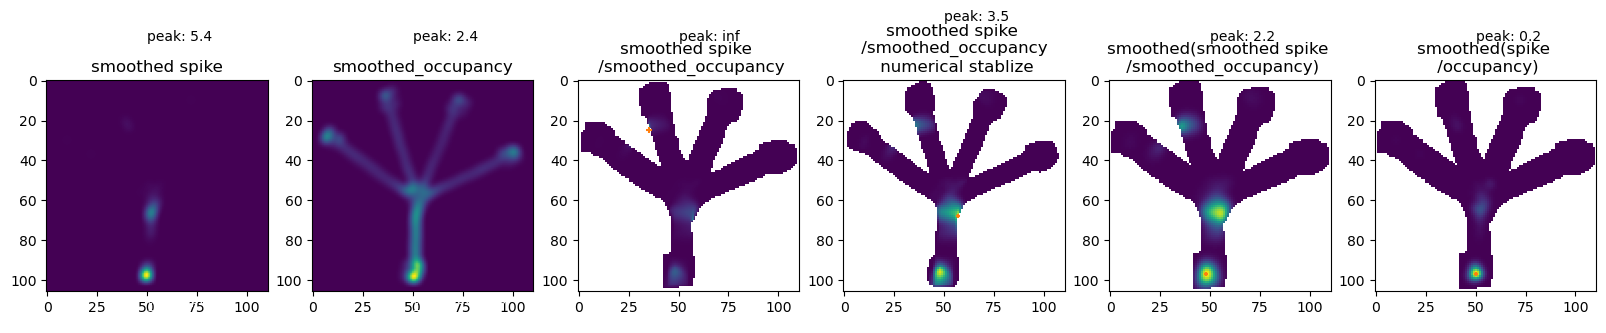

In [396]:
fig, axes = plt.subplots(1,6, figsize = (20,5), squeeze = True)

axes[0].imshow(smoothed_spike)
axes[0].set_title('smoothed spike')
axes[0].text(50,-20,'peak: '+str(np.round(np.nanmax(smoothed_spike),1)))
axes[0].text(50,120,'total spikes\n'+str(int(np.sum(smoothed_spike))),color = 'white')

axes[1].imshow(smoothed_occupancy)
axes[1].set_title('smoothed_occupancy')
axes[1].text(50,-20,'peak: '+str(np.round(np.nanmax(smoothed_occupancy),1)))
axes[1].text(50,120,'total seconds\n'+str(np.round(np.sum(smoothed_occupancy),1)),color = 'white')

axes[2].imshow(place_field_plot)#,vmax = np.quantile(place_field,1))
max_loc = np.unravel_index(np.nanargmax(place_field_plot),np.shape(place_field_plot))
axes[2].scatter(max_loc[1],max_loc[0],20,marker = '+',color = 'C1')
axes[2].set_title('smoothed spike \n /smoothed_occupancy')
axes[2].text(50,-20,'peak: '+str(np.round(np.nanmax(place_field_plot.ravel()),1)))

axes[3].imshow(place_field_stable)#,vmax = np.quantile(place_field,1))
max_loc = np.unravel_index(np.nanargmax(place_field_stable),np.shape(place_field_stable))
axes[3].scatter(max_loc[1],max_loc[0],10,marker = '+',color = 'C1')
axes[3].set_title('smoothed spike \n /smoothed_occupancy \n numerical stablize')
axes[3].text(50,-30,'peak: '+str(np.round(np.nanmax(place_field_stable.ravel()),1)))

axes[4].imshow(smoothed_place_field)
max_loc = np.unravel_index(np.nanargmax(smoothed_place_field),np.shape(smoothed_place_field))
axes[4].scatter(max_loc[1],max_loc[0],10,marker = '+',color = 'C1')
axes[4].set_title('smoothed(smoothed spike \n /smoothed_occupancy)')
axes[4].text(50,-20,'peak: '+str(np.round(np.nanmax(smoothed_place_field),1)))

axes[5].imshow(smoothed_place_field2)
max_loc = np.unravel_index(np.nanargmax(smoothed_place_field2),np.shape(smoothed_place_field2))
axes[5].scatter(max_loc[1],max_loc[0],10,marker = '+',color = 'C1')
axes[5].set_title('smoothed(spike \n /occupancy)')
axes[5].text(50,-20,'peak: '+str(np.round(np.nanmax(smoothed_place_field2),1)))

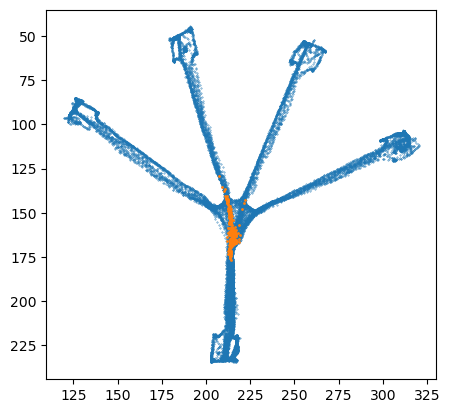

In [375]:
plt.scatter(pos2d.head_position_x,pos2d.head_position_y, s = 0.1)
plt.scatter(pos2d_spike_time.head_position_x,pos2d_spike_time.head_position_y, s = 1)
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')